In [16]:
import os
import glob
import itertools
import string
from os import path
from collections import defaultdict
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

import nltk
from nltk.corpus import stopwords
import textract
from sklearn.feature_extraction.text import TfidfVectorizer
import stylecloud

import spacy
from spacy import displacy

# Utils

In [2]:
def freq_dist_to_csv(fd, name):
    df = pd.DataFrame(fd.most_common())
    df.columns = ["word", "freq"]
    df.to_csv(path.join("processed", name + ".csv"))

In [124]:
stop_words = set()
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(string.punctuation))
stop_words = stop_words.union({
    "purdue",
    "@",
    "et",
    "al"
})

digits_re = re.compile(r"\w?\d+\w?")

def get_tokens_from_text(text):
    tokens = []
    for token in nltk.tokenize.word_tokenize(text):
        if token not in stop_words and not digits_re.fullmatch(token):
            tokens.append(token.lower())
            
    return tokens

def get_bigrams_from_text(text):
    tokens = []
    for token in nltk.bigrams(map(lambda x: x.lower(), nltk.tokenize.word_tokenize(text))):
        if all(map(lambda x: x not in stop_words and not digits_re.fullmatch(x), token)):
#         if token[0] not in stop_words and not digits_re.fullmatch(token):
            tokens.append(token)
            
    return tokens

In [14]:
def save_text_file(text, name):
    with open(path.join("text", name + ".txt"), "w") as f:
        f.write(text)

# Processing

In [11]:
# not used
pdfs = glob.glob('./papers/*/*')

for pdf in pdfs:
    category = pdf.split("/")[2]
    paper_name = pdf.split("/")[3]
    text = textract.process(pdf).decode("utf-8").lower()
    save_text_file(text, f"{category}-{paper_name}")

In [18]:
pdfs = glob.glob('./papers/*/*')
pdfs_text = {}
for pdf in pdfs:
    category = pdf.split("/")[2]
    paper_name = pdf.split("/")[3]
    pdfs_text[(category, paper_name)] = textract.process(pdf).decode("utf-8").lower()

In [125]:
tokens_by_category = defaultdict(list)

for key in pdfs_text:
    category, _ = key
    text = pdfs_text[key]
#     tokens_by_category[category] += get_tokens_from_text(text)
    tokens_by_category[category] += get_bigrams_from_text(text)


frequencies_by_category = {}
for category in tokens_by_category:
    frequencies_by_category[category] = nltk.FreqDist(tokens_by_category[category])

In [ ]:
for category in frequencies_by_category:
    freq_dist_to_csv(frequencies_by_category[category], category)

# Plots

In [126]:
total_df = None

for category in frequencies_by_category:
    freqs = frequencies_by_category[category].most_common(100)
    df = pd.DataFrame(freqs)
    df.columns = ['word', category]
    
    if isinstance(total_df, type(None)):
        total_df = df
    else:
        total_df = pd.merge(total_df, df, on="word")

In [127]:
total_df['sum'] = total_df['vaping'] + total_df['ards'] + total_df['mers']
total_df = total_df.sort_values(by="sum", ascending=False)

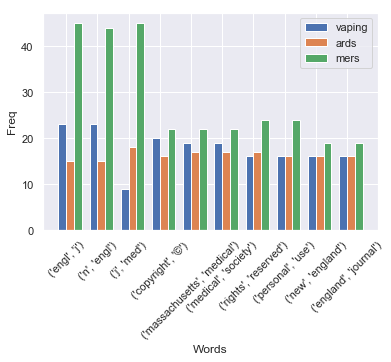

In [128]:
def plot_bars(df):
    fig, ax = plt.subplots()
    width = 0.25
    ind = np.arange(df.shape[0])
    
    plt.bar(ind, df.vaping, width, label="vaping")
    plt.bar(ind + width, df.ards, width, label="ards")
    plt.bar(ind + width * 2, df.mers, width, label="mers")
    
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(df.word, rotation=45)
    
    ax.autoscale_view()
    ax.legend()
    ax.set_ylabel("Freq")
    ax.set_xlabel("Words")

plot_bars(total_df[:10])

In [74]:
total_df.vaping.to_numpy()

array([131, 104,  28,  23,  84,  23,  30,  48,  23,  72,  38,  53,  35,
        67,  26,  49,  51,  34,  39,  32,  23,  23,  24])

# Spacy Stuff

In [5]:
nlp = spacy.load("en_core_web_md")
doc = nlp(pdfs_text[('vaping', '2012_0.pdf')])

In [15]:
get_tokens_from_text(pdfs_text[('vaping', '2012_0.pdf')])

['chest',
 'electronic',
 'cigarettes',
 'thing',
 'free',
 'lunch…or',
 'puff',
 'pulmonary',
 'cardiac',
 'mediascine',
 'practitioners',
 'many',
 'us',
 'doubt',
 'asked',
 'patients',
 'smoke',
 'so-called',
 '“',
 'electronic',
 'cigarettes',
 '”',
 'e-cigarettes',
 'devices',
 'termed',
 'electronic',
 'nicotine',
 'delivery',
 'systems',
 'ends',
 'world',
 'health',
 'organization',
 'available',
 'us',
 'market',
 'since',
 '2007.',
 'patients',
 'likely',
 'heard',
 'far',
 'devices',
 'marketing',
 'chat',
 'rooms',
 'word',
 'mouth',
 'physicians',
 'medical',
 'literature',
 'ends',
 'currently',
 'regulated',
 'us',
 'food',
 'drug',
 'administration',
 'fda',
 'medical',
 'devices—',
 'recent',
 'court',
 'decisions',
 'denied',
 'agency',
 'right',
 'oversight—manufacturers',
 'ends',
 'required',
 'establish',
 'either',
 'safety',
 'efﬁ',
 'ﬁcacy',
 'data',
 'answer',
 'patients',
 '’',
 'queries',
 'products',
 'e-cigarettes',
 'smoking',
 'cessation',
 'tool',
 'ha

In [8]:
displacy.render(doc, style="ent")

# Other

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(pdfs_text.values())

In [ ]:
x = X.toarray()

In [ ]:
features = np.array(vectorizer.get_feature_names())

In [ ]:
stop_words = set()
# stop_words = set(features[x.max(axis = 0) < 0.1])
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(string.punctuation))
stop_words = stop_words.union({str(x) for x in range(100)})

In [ ]:
tokens = []

for text in pdfs_text.values():
    for token in nltk.tokenize.word_tokenize(text):
        if token not in stop_words:
            tokens.append(token)

fd = nltk.FreqDist(tokens)

In [ ]:
# fd.most_common()

for word, freq in fd.most_common()[:5]:
    plt.bar(word, freq)

In [ ]:
pd

In [ ]:
stylecloud.gen_stylecloud(pdfs_text[pdf], icon_name="fas fa-smoking")